# Spatial slices integration for homologous individual samples
This tutorial demonstrates MISTIC’s ability to integrate spatial slices of homologous individuals. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1Rsa7dLiUKyZWu05n0hsKuBlMvlaTWf3P?usp=drive_link

## Loading and Processing

       MISTIC Pipeline Started

[Step 1/5] Loading and Preprocessing Data...
Found 4 files. Loading...
Loaded: 151673
Loaded: 151674
Loaded: 151675
Loaded: 151676
Number of common genes: 1134

[Step 2/5] Running BANKSY and Preparing Matrices...
Starting BANKSY computation. Results will be saved to ./output/banksy_processed...

Median distance to closest cell = 137.00364958642524

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----


Median distance to closest cell = 137.0036

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.17 s ----

---- Ran generate_spatial_distance_graph in 0.03 s ----

---- Ran theta_from_spatial_graph in 0.05 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.23 s ----

----- Plotting theta Graph -----
Runtime Dec-22-2025-09-50

1134 genes to be analysed:
Gene List:
Index(['AASDHPPT', 'ABCA2', 'ABI1', 'AC004158.1', 'A

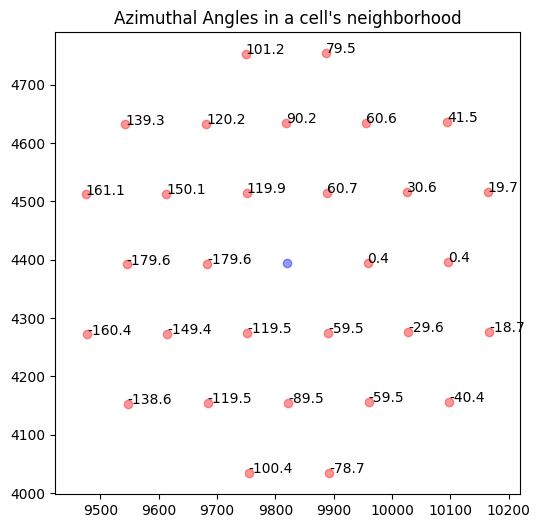

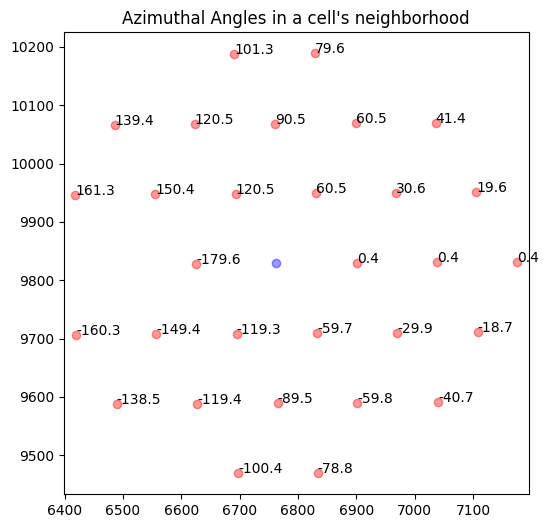

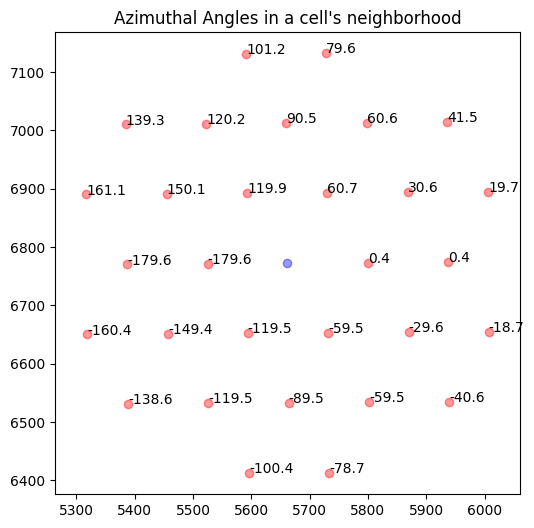

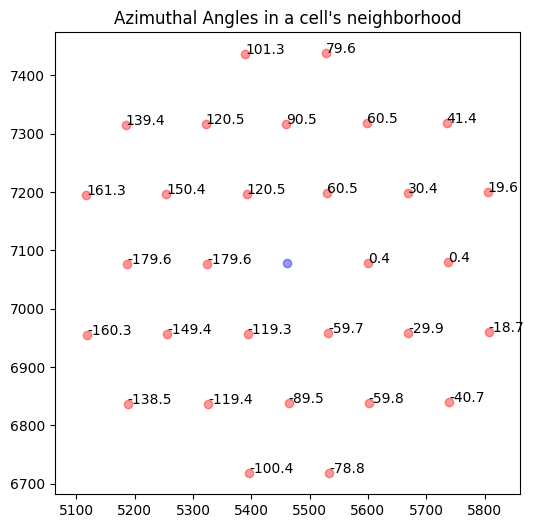

In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import MISTIC
INPUT_DIR = os.path.join('data', 'DLPFC')
OUTPUT_BANKSY_DIR = "./output/banksy_processed"

OUTPUT_FILE = os.path.join('output', 'mistic_result.h5ad')
# Preprocessing
N_TOP_GENES = 5000
# Graph Construction Parameters
SPATIAL_NEIGHBORS = 6  # k for spatial graph
SPATIAL_RADIUS = 150.0  # Radius for spatial graph
# Model Training Parameters
IS_HETEROGENEOUS = False  # Use GCN for output layer if True & dense MNN
NUM_EPOCHS = 500
CONTRASTIVE_WEIGHT = 0.05  # Coefficient for contrastive loss
LEARNING_RATE = 0.001
SEED = 42
print("==========================================")
print("       MISTIC Pipeline Started")
print("==========================================")
# ==========================================
# 2. Load and Preprocess
# ==========================================
print("\n[Step 1/5] Loading and Preprocessing Data...")
# Load .h5ad files and perform normalization
raw_adatas, filenames = MISTIC.load_and_preprocess(INPUT_DIR,n_top_genes=N_TOP_GENES)
# Align genes across all slices (intersection)
aligned_adatas = MISTIC.align_common_genes(raw_adatas)

# ==========================================
# 3. Generate BANKSY Features
# ==========================================
print("\n[Step 2/5] Running BANKSY and Preparing Matrices...")

# Compute Banksy matrices and concatenate original data
# Note: raw_adatas memory is cleared inside this function
adata_concat = MISTIC.get_banksy_results(aligned_adatas,filenames,output_dir = OUTPUT_BANKSY_DIR )

## Constructing Multi-View Graphs

In [2]:
print("\n[Step 3/5] Constructing Multi-View Graphs...")
X_adata, X_expr, X_gra, adj_concat, spatial_adj_concat, avg_mnn = MISTIC.construct_graph(banksy_dir=OUTPUT_BANKSY_DIR)


[Step 3/5] Constructing Multi-View Graphs...
Loading files from ./output/banksy_processed...
Processing 151673_banksy.h5ad...
  --> Average degree: 28.9045
Processing 151674_banksy.h5ad...
  --> Average degree: 28.9689
Processing 151675_banksy.h5ad...
  --> Average degree: 29.1486
Processing 151676_banksy.h5ad...
  --> Average degree: 29.0737
Concatenating data...
Constructing block diagonal matrices...
Computing Cross-Slice MNN...
MNN Average Degree: 12.1293
Cleaning up intermediate directory: ./output/banksy_processed
Cleanup successful.


## Running MISTIC AutoEncoder

In [3]:
print("\n[Step 4/5] Running MISTIC AutoEncoder...")

# Run the training loop
adata_result, model = MISTIC.run_training(
    adata_concat=adata_concat,
    X_adata=X_adata,
    X_expr=X_expr,
    X_gra=X_gra,
    adj_concat=adj_concat,
    spatial_adj_concat=spatial_adj_concat,
    mnn_avg_degree=avg_mnn,
    # Parameters
    is_heterogeneous=IS_HETEROGENEOUS,
    num_epochs=NUM_EPOCHS,
    contrastive_weight=CONTRASTIVE_WEIGHT,
    lr=LEARNING_RATE,
    seed=SEED
)

    # ==========================================
    # 6. Save Results
    # ==========================================
print(f"\n[Step 5/5] Saving results to {OUTPUT_FILE}...")

adata_result.write_h5ad(OUTPUT_FILE)


[Step 4/5] Running MISTIC AutoEncoder...
Running training on: cuda
Hyperparameters -> Heterogeneous: False, Epochs: 500, Contrastive Weight: 0.05
Preparing tensors and graphs...
Generating contrastive learning pairs...
Initializing AutoEncoder (Heterogeneous=False, MNN_Avg_Deg=12.13)...
Starting training for 500 epochs...


Training MISTIC: 100%|██████████| 500/500 [01:00<00:00,  8.22epoch/s, Con=0.2835, Rec=0.8579, Total_Loss=0.8720]


Training finished. Extracting embeddings...
Embedding saved to adata_concat.obsm['MISTIC']

[Step 5/5] Saving results to output/mistic_result.h5ad...


## Visualization

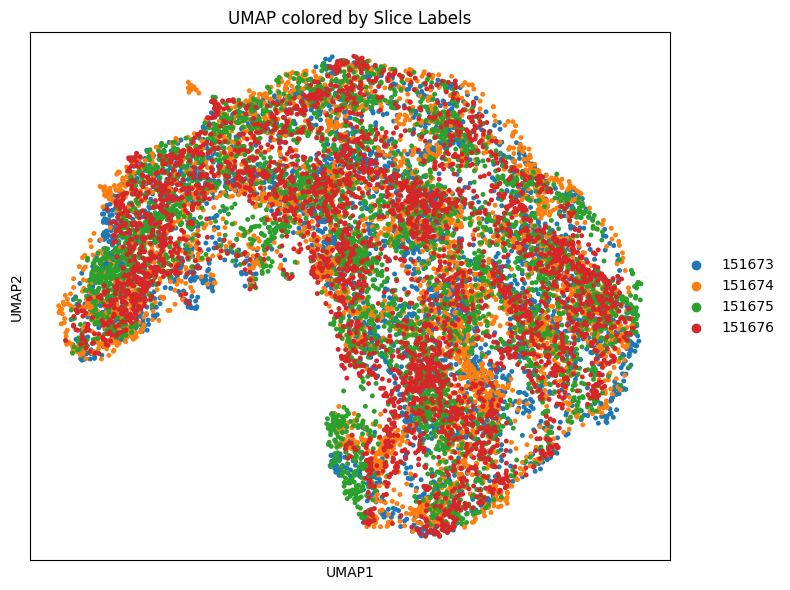

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
sc.pp.neighbors(adata_result, use_rep='MISTIC', n_neighbors=15)
sc.tl.umap(adata_result,random_state=42)

def plot_umap(adata_result, color_by, title=None, save_path=None):

    fig, ax = plt.subplots(figsize=(8, 6))

    sc.pl.umap(
        adata_result,
        color=color_by,
        show=False,
        title=title,
        frameon=True,
        ax=ax,
        size=50,
        legend_loc='right margin',
        legend_fontsize=10,
        legend_fontoutline=2
    )


    plt.tight_layout()

    if save_path:

        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:

        plt.show()

# slice_labels UMAP
plot_umap(adata_result, color_by=['slice_labels'], title='UMAP colored by Slice Labels')

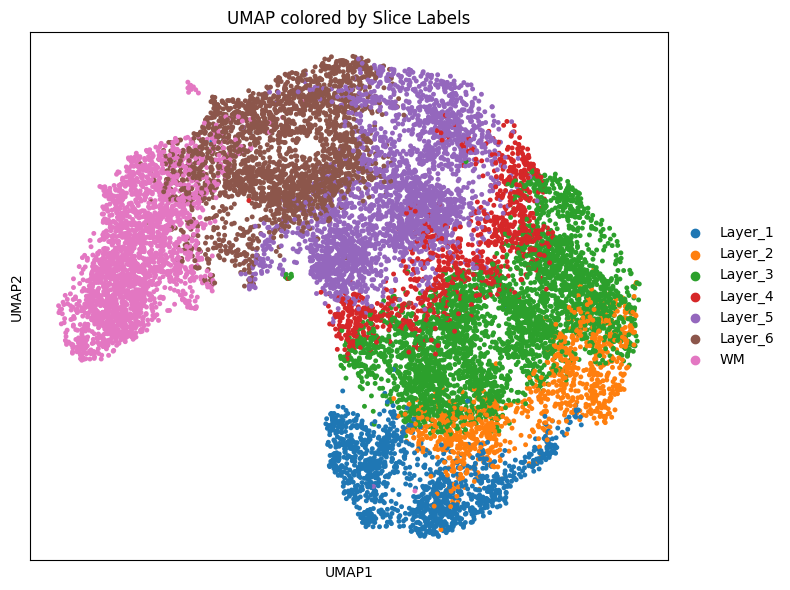

In [6]:
plot_umap(adata_result, color_by=['Ground Truth'], title='UMAP colored by Slice Labels')